In [79]:
from glob import glob
from xmltodict import parse
import networkx as nx
import pandas as pd
from matplotlib import pyplot as plt


Bad key text.latex.unicode in file /Users/fukai/.matplotlib/stylelib/paper-default2.mplstyle, line 46 ('text.latex.unicode: True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.4.2/matplotlibrc.template
or from the matplotlib source distribution
Duplicate key in file PosixPath('/Users/fukai/.matplotlib/stylelib/paper-default.mplstyle'), line 38 ('legend.framealpha: 1.0')


In [9]:
track_files = glob("../*.xml")

In [76]:
for track_file in track_files:
    with open(track_file,"r") as f:
        track_xml=parse("\n".join(f.readlines()))
    spot_keys=["@ID","@FRAME","@TOTAL_INTENSITY","@POSITION_X","@POSITION_Y"]
    spotss=list(map(lambda x: x["Spot"] if isinstance(x["Spot"],list) else [x["Spot"]],
        track_xml["TrackMate"]["Model"]['AllSpots']['SpotsInFrame']
    ))
    spots_df=pd.DataFrame.from_records(sum(spotss,[]))[spot_keys]

    track_ids=list(map(lambda x:x["@TRACK_ID"],
        track_xml["TrackMate"]["Model"]["FilteredTracks"]["TrackID"]))
    id_edgess = list(map(lambda x: (x["@TRACK_ID"],x["Edge"]) 
                            if isinstance(x["Edge"],list) 
                            else (x["@TRACK_ID"],[x["Edge"]]),
        filter(lambda x : x["@TRACK_ID"] in track_ids,
            track_xml["TrackMate"]["Model"]["AllTracks"]["Track"]
        )))
    edge_dfs=[]
    for track_id,edges in id_edgess:
        edge_keys=["@SPOT_SOURCE_ID","@SPOT_TARGET_ID","@LINK_COST"]
        edge_df=pd.DataFrame.from_records(edges)[edge_keys]
        edge_df["track_id"]=track_id
        edge_dfs.append(edge_df)
    edge_df=pd.concat(edge_dfs)

    edge_df2=pd.merge(edge_df,
        spots_df.add_prefix("source_"),
        left_on="@SPOT_SOURCE_ID",
        right_on="source_@ID")
    assert len(edge_df) == len(edge_df2)
    edge_df2=pd.merge(edge_df2,
            spots_df.add_prefix("target_"),
            left_on="@SPOT_TARGET_ID",
            right_on="target_@ID")
    assert len(edge_df) == len(edge_df2)
    edge_df2.columns=list(map(lambda x:x.replace("@","").lower(),edge_df2.columns))
    edge_df2=edge_df2.drop(['source_id','target_id'],axis=1)

    edge_df2.to_csv(track_file.replace(".xml",".csv"))

findfont: Font family ['IPAPGothic'] not found. Falling back to DejaVu Sans.


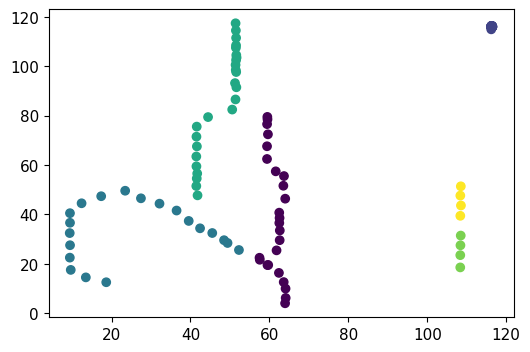

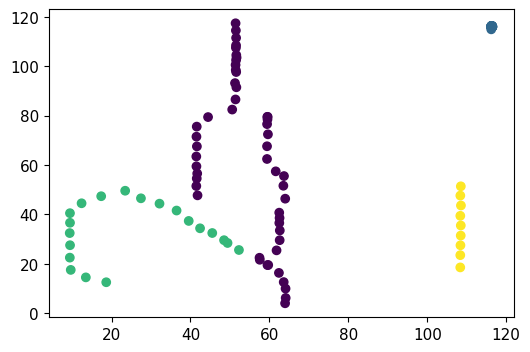

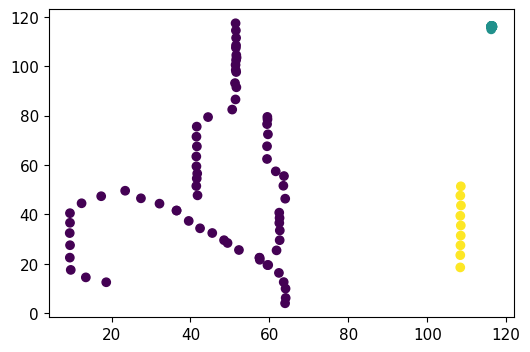

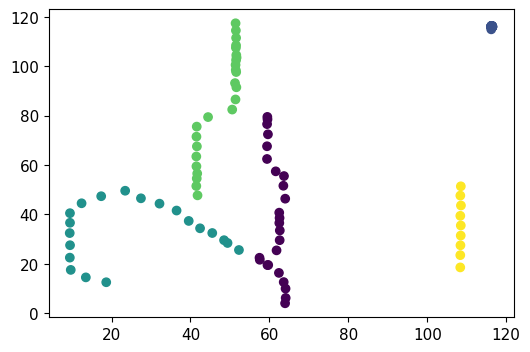

In [80]:
for track_file in track_files:
    edge_df2=pd.read_csv(track_file.replace(".xml",".csv"))
    plt.scatter(edge_df2["source_position_x"],
                edge_df2["source_position_y"],
                c=edge_df2["track_id"])
    for i, row in edge_df2.iterrows():
        plt.plot([edge_df2["source_position_x"],edge_df2["target_position_x"]],
                 [edge_df2["source_position_y"],edge_df2["target_position_y"]],"-k")
    plt.show()